In [24]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import join
import pandas
import os
import cv2
import random

In [25]:
data = "flowers/"

folders = os.listdir(data)

print(folders)

['daisy', 'dandelion', 'flowers', 'rose', 'sunflower', 'tulip']


In [26]:
image_names = []
train_labels = []
train_images = []

size = 334,334

for folder in folders:
    for file in os.listdir(os.path.join(data,folder)):
        if file.endswith("jpg"):
            image_names.append(os.path.join(data,folder,file))
            train_labels.append(folder)
            img = cv2.imread(os.path.join(data,folder,file))
            im = cv2.resize(img,size)
            train_images.append(im)
        else:
            continue

In [27]:
train_images = np.array(train_images)

In [34]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [35]:
le=LabelEncoder()
Y=le.fit_transform(train_labels)
train_label=to_categorical(Y,5)

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X_train,X_test,Y_train,Y_test= train_test_split(train_images, train_label, test_size=0.1, random_state=2021)

In [39]:
X_train,X_val,Y_train,Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=2021)

In [41]:
def decode_image(image, label=None):
    image = tf.cast(image, tf.float32) / 255.0  
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [42]:
AUTO = tf.data.experimental.AUTOTUNE

In [43]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [44]:
BATCH_SIZE = 8 * strategy.num_replicas_in_sync

In [45]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train,Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(len(train_label))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_test,Y_test))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [51]:
EPOCHS = 1

Learning rate schedule: 1e-05 to 1e-05 to 1e-05


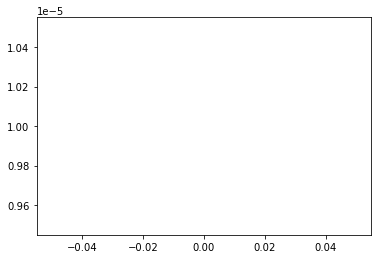

In [52]:
def lrfn(epoch):
    LR_START = 0.00001
    LR_MAX = 0.0004
    LR_MIN = 0.00001
    LR_RAMPUP_EPOCHS = 8
    LR_SUSTAIN_EPOCHS = 0
    LR_EXP_DECAY = .8
    
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [53]:
with strategy.scope():  
    covn_base = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False ,input_shape=(334,334,3))
    covn_base.trainable = True

    model = tf.keras.Sequential([
        covn_base,
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.summary()        
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 9, 9, 1536)        54336736  
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 9, 1536)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 7685      
Total params: 54,344,421
Trainable params: 54,283,877
Non-trainable params: 60,544
_________________________________________________________________


In [55]:
TRAIN_STEPS_PER_EPOCH = Y_train.shape[0] // BATCH_SIZE
VALID_STEPS_PER_EPOCH = Y_val.shape[0] // BATCH_SIZE

In [56]:
history = model.fit(x = train_dataset,
                    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                    epochs = EPOCHS,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS_PER_EPOCH,
                    callbacks=[lr_schedule])


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
437/437 [==============================] - 6645s 15s/step - loss: 1.1461 - accuracy: 0.5504 - val_loss: 0.4115 - val_accuracy: 0.8698


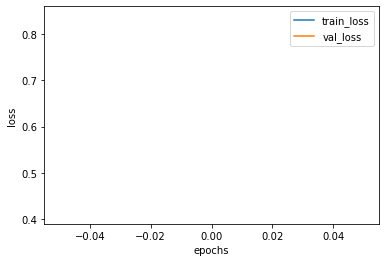

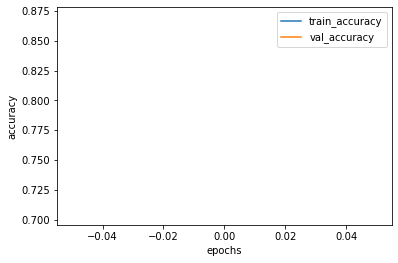

In [58]:
# plot loss and accuracy image
history_dict = history.history
train_loss = history_dict["loss"]
train_accuracy = history_dict["accuracy"]
val_loss = history_dict["val_loss"]
val_accuracy = history_dict["val_accuracy"]

# figure 1
plt.figure()
plt.plot(range(EPOCHS), train_loss, label='train_loss')
plt.plot(range(EPOCHS), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

# figure 2
plt.figure()
plt.plot(range(EPOCHS), train_accuracy, label='train_accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [59]:
scores = model.evaluate(test_dataset, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

55/55 [==============================] - 186s 3s/step - loss: 0.3748 - accuracy: 0.8799
Test loss: 0.3747858703136444
Test accuracy: 0.8799076080322266
